# DataScience 2000B / Integrated Science 2000B Final 2023


## Your Student ID: ########

## General 
The instruction for the final exam for DS2000B / IS2002B is included in this Jupyter Notebook. 

- You are allowed to use any document and source and look up documents on the internet. You are not allowed to use chatGPT, copilot, or any other AI engine that provides programming assistance. 
- You or not allowed to share documents, or communicate in any other way with people during period of final. Given that there are students with extra time, this is until 6pm.  
- You are only allowed to use the python packages listed under "preliminaries" - the use of other regression (e.g., statsmodels, numpy polyfit) or machine learning toolboxes (e.g., sklearn) is not permitted. 
- All the code you are using from previous assignments or labs needs to be included in the notebook. 
- Most questions also require some written answer. The answer to these questions should be given in full English sentences. 
- All Figures should be appropriately labeled in x and y axis.  
- The Final exam needs to be submitted on OWL (Assignment) before 5:30pm. If you have approved accommodation, you need to submit after 3.5 hrs + your extra time after the start of the exam at 2pm.
- Any final submitted later than the alloted time will be scored with 0 pts.  
- **It is your responsibility that you submit the correct file. Please check that you uploaded the correct file by downloading the submitted version and opening it in jupyter before you leave the exam room.** 

## Problem description 

Companies are increasingly using Machine Learning algorithms and Artificial Intelligence (AI) to select the job applicants that they want to bring in for an interview. Many applications are nowadays not seen by a human at all anymore - the initial screening is done purely by algorithms. 

These algorithms work in quite similar ways to the classification algorithms (logistic regression) that you've learned in class: They are models with many parameters, which have been optimized on a training set of data (using a loss function and gradient). The best algorithm will then be picked by testing its predictive performance on a left-out test set. 

The data the algorithm is trained on a large number of applications from previous job-applicants. It tries to predict whether the job candidate was judged to suitable for the job after the interview. These candidates are shortlisted by the algorithm (shortlist, coded 0: not shortlisted, 1: shortlisted).

The main problem with these algorithms is that they are often biased, simply because the original training data was biased. That is, if more white males were invited to an interview than females of ethnic minorities, then the algorithm learns that a name such as "Alexander" predicts better chances of being suitable for the job than "Aaliyah", even if all the other performance indicators are matched. 

The company that sells the algorithm claims that the algorithm is unbiased. However, you are more critical, and want to test whether this is really true, before recommending to use the algorithm for hiring. 

You decide to conduct an experiment to test the influence of the first name on the decision. 
Because the algorithm detects when it gets the same application twice (and dismisses them), every single application must be slightly different. Since you have taken Data Science 2000 - this is no problem for you! You write a program that generate 1500 applications, each with a random GPA, degree, University, font, formatting.

You then *randomly* assign whether the first name is male or female. You also *randomly choose* whether the first and last name sound White Canadian, or to belong to an ethnic minority (black, first nation, asian, persian). The CVs are then submitted to the algorithm that then gives you a decision of "shortlisted" and "not shortlisted". 

The dataset `recruitment.csv` contains the data with the data frame: 

* age: age of the candidate in years
* undergrad_degree: DataSci, CompSci, or Stats
* gender: Likely gender indicated by first name on application (male / female)
* minority: Whether the name sounds like it belongs to a Canadian of Caucasian descent or not (0: caucasian, 1: non-caucasian)
* shortlist: Whether the candidate was shortlisted by the algorithm (0: not shortlisted, 1: shortlisted)

In [1]:
# Preliminaries - you are only allowed to import the following packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as so

In [6]:
df = pd.read_csv('recruitment.csv')

In [7]:
df.head()

,age,undergrad_degree,gender,minority,GPA,shortlist
0,24,CompSci,female,1,3.73,1
1,31,DataSci,female,1,2.82,0
2,30,DataSci,female,1,1.83,0
3,28,DataSci,female,1,2.32,0
4,28,CompSci,female,0,3.91,0


## Task 1: (26pts)
### Questions 1.1: (3pts)
Calculate the probability of being shortlisted by the algorithm with a male and female name. Report the probabilities. 

In [17]:
#Create a cross table 
table = pd.crosstab(df["shortlist"], df["gender"], margins=True)
display(table)

f_sl = table.iloc[1, 0]/table.iloc[2, 0]
m_sl = table.iloc[1, 1]/table.iloc[2, 1]
print(f'Probabiblity of being shortlisted given that you are female: {f_sl*100:.2f}')
print(f'Probabiblity of being shortlisted given that you are male: {m_sl*100:.2f}')

gender,female,male,All
shortlist,,,
0,542,559,1101
1,179,220,399
All,721,779,1500


Probabiblity of being shortlisted given that you are female: 24.83
Probabiblity of being shortlisted given that you are male: 28.24


### Question 1.2: (3pts)
Write a function that takes a data frame as input and then returns the difference in probability of being shortlisted by the algorithm between males and females. 

Call the function with the real data and report the difference in percentage of male and female candidates being shortlisted. 

In [18]:

def diffMean(df):
    
    table = pd.crosstab(df["shortlist"], df["gender"], margins=True)

    f_sl = table.iloc[1, 0]/table.iloc[2, 0]
    m_sl = table.iloc[1, 1]/table.iloc[2, 1]
    
    return m_sl-f_sl

In [195]:
print(f'The difference in male and female shortlist percentage is {diffMean(df)*100:.2f}')

The difference in male and female shortlist percentage is 3.41


### Question 1.3: (8pts)
In this question, you will determine whether the gender difference found in Q.1.2 is significant.

You want to test the hypothesis that the algorithm takes the (likely) gender of the first name on the application into account when making shortlisting decisions. 

* Formulate the Null-hypothesis
* Conduct a randomization test where you randomly randomly shuffle the column of the dataframe that is exchangeable under the Null hypothesis. 
* Plot a histogram of the difference in probability between male and female candidates. 
* Choose whether you are conducting a one-sided or two-sided test
* Report the p-value for testing the the hypothesis and draw a conclusion

H0: Gender does not influence the chance of being shortlisted (H0 = 0)

HA: Gender has an influence on being shortlisted (H0 != 0)

In [196]:

def randomization(df, func, colName, numIter=500, numSides=1, Bins=None):

    List = []
    
    #The original test statistic is calculated using the func function and stored in the Emperical_Value variable. 
    Emperical_Value = func(df)
    
    #The code then enters a while loop and performs the following steps numIter times:
    n = 0
    while n < numIter:

        #Copy table and reset index 
        table = df.copy()
        table.reset_index(inplace=True)

        #Shuffle the column 
        idx = table.index
        idx_arr = np.arange(0, len(idx))
        np.random.shuffle(idx_arr)

        #Add the shuffled column into the dataframe and return the dataframe 
        shuffled_column = table[colName].iloc[idx_arr]
        shuffled_column_id = shuffled_column.reset_index(drop=True)
        table[colName] = shuffled_column_id
        table.drop(['index'], axis=1, inplace=True)
    
        print(f'Iteration: {n}', end = '\r')
        
        #Sometimes creates a Nan value which needs to be filtered out 
        point = [func(table)]
        NAN = not(any(np.isnan(point)))
        INF = not(any(np.isinf(point)))
        if (NAN and INF):
            List.append(point)
            n+=1

    #Get the p-value from two sides:
    data = np.array(List)
    
    if numSides == 2:
        P = np.average(np.absolute(data) >= Emperical_Value)
    else:
        P = np.average(data >= Emperical_Value)
        
    #Lower tail transformation for single end and double ends
    if P > 0.5:
        P = 1 - P
        
    #Plot the emperical value
    plt.axvline(x=Emperical_Value, color='r', linewidth=2, label='Emperical Result')
    
    #Plot the data as a histogram and show the p-value 
    plt.title(colName)
    if Bins == None:
        plt.hist(data)
    else:
        plt.hist(data, bins = Bins)
        
    plt.legend()
    plt.ylabel('Counts')
    plt.xlabel('Probability')
    plt.title('Randomization test histogram using test statistic')
    plt.show()

    print(f'P-value: {P:.8f}')
    print()

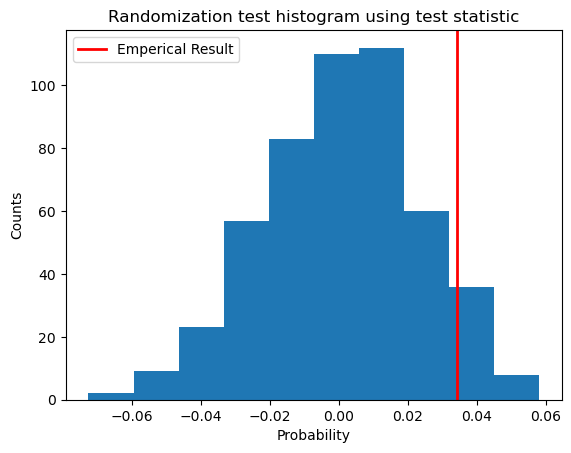

P-value: 0.15600000



In [58]:
randomization(df, diffMean, colName='shortlist', numSides=2)

We are using a two sided test because HA is an inequality statement and because p = 0.16 > 0.05, the results are not significant and we do not have enough evidence to reject H0. Therefore, with 0.05 significance level, gender does not influence the applicants chance of being shortlisted.

### Question 1.4 (5pts)
In this question we will test whether the algorithm is biased against women of ethnic minorities. We will do this by comparing the probability of being shortlisted for a application with a female minority name to anybody else. 

Add a new column entitled 'female_minority' that is 1 if the name indicates the the applicant is both female AND a member of a minority, and 0 otherwise. 

Write a function that returns the difference in the probability of getting shortlisted for female members of an ethnic minority against anybody else. Report the difference between the two groups. 

In [44]:


df['female_minority'] = np.where(((df['minority'] == 1) & (df['gender'] == 'female')), 1, 0)

In [227]:
df.head()

,age,undergrad_degree,gender,minority,GPA,shortlist,female_minority,dumGender,dumCompSci,dumStats,ZGPA,Zage,ZdumGender,Zminority
0,24,CompSci,female,1,3.73,1,1,0,1,0,1.159480,-1.583638,-1.039097,0.979869
1,31,DataSci,female,1,2.82,0,1,0,0,0,-0.795810,0.851658,-1.039097,0.979869
2,30,DataSci,female,1,1.83,0,1,0,0,0,-2.922994,0.503758,-1.039097,0.979869
3,28,DataSci,female,1,2.32,0,1,0,0,0,-1.870146,-0.192041,-1.039097,0.979869
4,28,CompSci,female,0,3.91,0,0,0,1,0,1.546241,-0.192041,-1.039097,-1.019864


In [229]:
table = pd.crosstab(df["shortlist"], df["female_minority"], margins=True)
display(table)
f_sl = table.iloc[1, 0]/table.iloc[2, 0]
m_sl = table.iloc[1, 1]/table.iloc[2, 1]

print(f_sl, m_sl)

female_minority,0,1,All
shortlist,,,
0,812,289,1101
1,326,73,399
All,1138,362,1500


0.28646748681898065 0.20165745856353592


In [54]:

def diffMean2(df):
    
    table = pd.crosstab(df["shortlist"], df["female_minority"], margins=True)
    f_sl = table.iloc[1, 0]/table.iloc[2, 0]
    m_sl = table.iloc[1, 1]/table.iloc[2, 1]
    
    return f_sl-m_sl

In [55]:
print(f'You are {diffMean2(df)*100:.2f} % more likely to get shortlisted if you are a female minority')

You are 8.48 % more likely to get shortlisted if you are a female minority


### Question 1.5: (7pts)
In this question you will determine whether the difference observed in Q.1.4 constitute significant discrimination against women of ethics minorities. 

You want to test the hypothesis that the algorithm is *less likely* to shortlist the candidate, if the name on the application suggests that the applicant is both female and a member of a minority.  

* Formulate the Null-hypothesis 
* Conduct a randomization test (with at least 5000 iterations) where you randomly randomly shuffle the column of the dataframe that is exchangeable under the Null hypothesis. 
* Plot a histogram of the difference in probability between male and female candidates. 
* Choose whether you are conducting a one-sided or two-sided test
* Report the p-value for testing the the hypothesis and draw a conclusion

H0: Being a female and a member of a minority does not influence the chance of being shortlisted (H0 = 0)

HA: Being a female and a member of a minority decreases your chance of being shortlisted (H0 > 0)

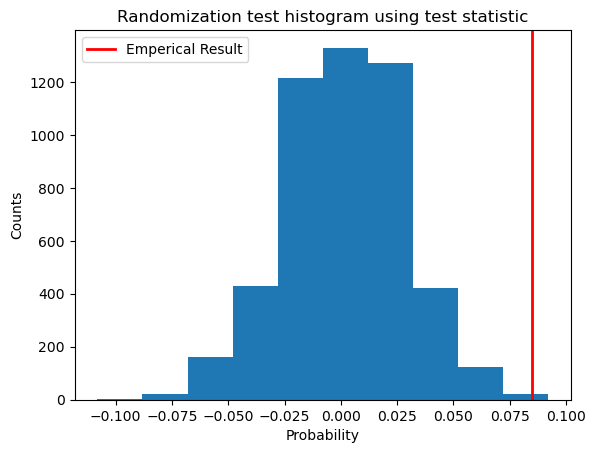

P-value: 0.00160000



In [230]:
randomization(df, diffMean2, colName='shortlist', numIter=5000)

We are using a one sided test because HA is an inequality statement and because p = 0.002 < 0.05, the results are significant and we do have enough evidence to reject H0 (Being a female and a member of a minority does not influence the chance of being shortlisted). Therefore, one can say with a significance level of 0.05 that the algorithim is less likely to shortlist a female minority than a non - female minority. 

## Task 2: (25pts)

Instead of just doing a randomization test to test your hypotheses, you decide that you also need to account for possible other differences between the applications. 
Even though you randomly assigned the name to each application, you cannot be sure that they are exactly matched between the groups. 
So you decided to build and test different models of the shortlisting decision of the algorithm. 

## Question 2.1: (4pts) 

Create dummy coded variables for gender (male / female) 
and undergraduate major (DataSci, CompSci, Stats).

You are free to choose on of the variables as comparison group - just be aware that it will influence the your interpretation of the regression coefficients later on. 

Based on your dummy variable, report the proportion of applications that have labels with having a "Data Science" Major. 

In [70]:
df['dumGender'] = np.where(df['gender']=='male', 1, 0)
df['dumCompSci'] = np.where(df['undergrad_degree']=='CompSci', 1, 0)
df['dumStats'] = np.where(df['undergrad_degree']=='Stats', 1, 0)

In [71]:
df.head(10)

,age,undergrad_degree,gender,minority,GPA,shortlist,female_minority,dumGender,dumCompSci,dumStats
0,24,CompSci,female,1,3.73,1,1,0,1,0
1,31,DataSci,female,1,2.82,0,1,0,0,0
2,30,DataSci,female,1,1.83,0,1,0,0,0
3,28,DataSci,female,1,2.32,0,1,0,0,0
4,28,CompSci,female,0,3.91,0,0,0,1,0
5,32,DataSci,male,0,3.00,1,0,1,0,0
6,24,Stats,female,0,2.82,0,0,0,0,1
7,30,CompSci,male,1,4.00,0,0,1,1,0
8,26,Stats,female,0,3.83,0,0,0,0,1
9,24,Stats,female,1,3.21,1,1,0,0,1


In [268]:
C = np.where(((df['dumCompSci'] == 0) & (df['dumStats'] == 0)), 1, 0)

p = sum(C)/len(C)
print(p)

0.34


The proportion of candidates that have a data science major are 34%

### Question 2.2: Build regression model (9pts)

Build a regression model to predict the shortlisting decision (1/0) of the algorithm based on the following variables:

* gender (dummy coded)
* undergrad_degree (dummy coded)
* minority
* GPA 


Written answer: From among multiple Regression, median regression, and logistic regression, choose the most appropriate regression technique and justify your choice. 

Estimate and report the parameters of your model. 

Written answer: Interpret the gender, minority, and undergraduate degree effects. Which of the groups does the algorithm have a preference for? 

Logistic regression is the most appropriate because the parameters are for discrete variables 

In [185]:
def logisticRegPredict(b, D, xname):
    
    yp = np.ones(len(D[xname].index)) * b[0]

    for i in range (len(xname)):
        yp += D[xname[i]] * b[i + 1]
    
    lyp = 1/(1+np.e**-yp)
    
    return lyp

def logisticRegLoss(b, D, y, xname):
    p = logisticRegPredict(b, D, xname)

    loss = - sum(y*np.log(p) + (1-y)*np.log(1 - p))     
    
    res = y - p
    deriv = np.zeros(len(b))
    deriv[0] = -(sum(res))
    
    for i in range(len(b) - 1):
        deriv[i+1] = -np.sum(D[xname[i]]*res)
    
    return loss, deriv

def logisticRegFit(D, y, xname, figure = True, b0=None):
    
    if b0 == None:
        b0 = np.zeros(len(xname) + 1)
        
    mi = so.minimize(logisticRegLoss, b0, args = (D, y, xname), jac = True)
    loss, deriv = logisticRegLoss(mi.x, D, y, xname)

    if len(xname) == 1 and figure:
        plt.scatter(D[xname[0]], y)
        
        yp = logisticRegPredict(mi.x, D, xname)
        idx = np.argsort(D[xname[0]])
        x_sorted = D[xname[0]][idx]
        yp_sorted = yp[idx]

        # Create a line plot of the predicted values
        plt.plot(x_sorted, yp_sorted)
        plt.scatter(D[xname[0]], yp)

    return mi.x, loss

In [236]:
Parameters, Loss = logisticRegFit(df, df['shortlist'], ['dumGender', 'dumCompSci', 'dumStats', 'minority', 'GPA'])

In [237]:
print(f'The Loss is {Loss:.5f}')
print(f'The parameters are {Parameters}')

The Loss is 857.04880
The parameters are [-1.75301804  0.19834489 -0.4103103  -0.21011037 -0.3352713   0.31107727]


The model is in favour of males (0.2>0) and those with higher GPA (0.3>0). For the degree, the favour is ranked by Data (0) science, stats(-0.2<0) and computer science (-0.4 <0). The model is also not in favour for minorities (-0.3<0). 

### Question 2.3: (8pts)
Use Model comparison to determine whether gender has an effect on the probability of being shortlisted, after we account for the variables (minority, undergrad_degree, and GPA). 

Compare the models using 50-fold cross-validation to determine the cross-validated prediction performance the two appropriate model.

Is there positive evidence (in the sense of Kass & Raftery, 1995) for an effect of gender on the algorithms decision, after we account for minority, undergrad_degree, and GPA.

In [188]:
def KfoldCVlogisticReg(D,y,xname, fitfcn=logisticRegFit,predictfcn=logisticRegPredict, K=50):
    N = len(y) #Number of observations
    yp= np.zeros(N)
    ind = np.arange(N)
    ind = np.floor(ind/N*K)
    
    # Get overall model fit 
    b_all, LL =fitfcn(D,y,xname,figure=False)
    
    if str(type(b_all)) != '<class \'list\'>':
        
        b_all = [b_all]
    # Loop over the crossvalidation folds 
    for i in range(K):

        b, r=fitfcn(D[ind!=i],y[ind!=i],xname,figure=False)
        
        yp[ind==i]=predictfcn(b,D[ind==i],xname)
    LLcv = sum(y*np.log(yp)+(1-y)*np.log(1-yp))
    return LLcv,LL 

In [190]:
R2cv,R2 = KfoldCVlogisticReg(df, df['shortlist'], ['dumGender', 'dumCompSci', 'dumStats', 'minority', 'GPA'], logisticRegFit, logisticRegPredict) 

In [191]:
R2cv_2,R2_2 = KfoldCVlogisticReg(df, df['shortlist'], ['dumGender'], logisticRegFit, logisticRegPredict) 

In [192]:
BF = R2cv-R2cv_2

print(BF)

7.116593696590371


There is strong evidence (BF = 7 > 3) for an effect of gender on the algorithms decision, after we account for minority, undergrad_degree, and GPA according to the Kass & Raftery, 1995

### Question 2.4 (4pts)
Now use the same approach as in Question 2.3 to test whether being a female AND a member of minority has an influence of the algorithms decision, after we  account for the influence of GPA and undergraduate degree. 

In [193]:
R2cv,R2 = KfoldCVlogisticReg(df, df['shortlist'], ['female_minority', 'dumCompSci', 'dumStats', 'GPA'], logisticRegFit, logisticRegPredict)
R2cv_2,R2_2 = KfoldCVlogisticReg(df, df['shortlist'], ['female_minority'], logisticRegFit, logisticRegPredict) 

BF = R2cv-R2cv_2

print(BF)

4.361323901680294


There is strong evidence (BF = 4 > 3) for an effect of being a female and a member of a minority on the algorithms decision, after we account for undergrad_degree, and GPA according to the Kass & Raftery, 1995

## Task 3: Regularized logistic regression (19pts)
Because there are so many potential variables that could influence the algorithm's decision, you want to implement a L2-regularized version of logistic regression. 
Having taken Data Science 2000, you decide to do it the hard (and heroic) way, and write the code yourself. That way you can be sure your really know what is going on!

### Question 3.1  (3pts)

Z-standarize the variables GPA, age, gender (dummy coded), minority (dummy coded). 

Check that the variables have after standardization (approximately) a mean of 0 and a standard deviation of 1 by reporting the mean and standard deviations of one of the variables. 

In [197]:
# Z-standardize the data
def zstandardize(d):
    d = (d-d.mean())/d.std()
    return d

df['ZGPA'] = zstandardize(df['GPA'])
df['Zage'] = zstandardize(df['age'])
df['ZdumGender'] = zstandardize(df['dumGender'])
df['Zminority'] = zstandardize(df['minority'])

In [198]:
df.head()

,age,undergrad_degree,gender,minority,GPA,shortlist,female_minority,dumGender,dumCompSci,dumStats,ZGPA,Zage,ZdumGender,Zminority
0,24,CompSci,female,1,3.73,1,1,0,1,0,1.159480,-1.583638,-1.039097,0.979869
1,31,DataSci,female,1,2.82,0,1,0,0,0,-0.795810,0.851658,-1.039097,0.979869
2,30,DataSci,female,1,1.83,0,1,0,0,0,-2.922994,0.503758,-1.039097,0.979869
3,28,DataSci,female,1,2.32,0,1,0,0,0,-1.870146,-0.192041,-1.039097,0.979869
4,28,CompSci,female,0,3.91,0,0,0,1,0,1.546241,-0.192041,-1.039097,-1.019864


### Question 3.2 (7pts)
Change the loss function for logistic regression (i.e. see Assignment 11 solutions) to include L2-regularization.

Regularize all regression coefficients except the intercept with a regularization coefficient of alpha = 0.1. 
Adjust the gradients accordingly.

Calculate the loss and gradients for the regularized logistic regression model, using the variables: 

* Intercept 
* age (z-standardized)
* GPA (z-standardized)
* gender (dummy coded and z-standardized)
* minority (dummy coded and z-standardized)


Report the loss and gradient for the regularized model (alpha = 0.1) and compare it to the loss for the unregularized model for the parameters 
`b= [-0.5,0.2,0.3,-0.2,-0.2]`
(these are the regression coefficients for [intercept, ageZ, GPAZ, genderZ, minorityZ])

Written answer: 
   * Why does the regularized model have a higher loss than the non-regularized model?
   * Which direction do you have to change the regression coefficient for the intercept to lower the loss? 


In [258]:
def logisticRegLoss2(b, D, y, xname, alpha=0.1):
    p = logisticRegPredict(b, D, xname)
    
    b = np.array(b)
    
    loss = - sum(y*np.log(p) + (1-y)*np.log(1 - p)) + alpha*sum(b[1:]**2)
    
    res = y - p
    deriv = np.zeros(len(b))
    deriv[0] = -(sum(res))
    
    for i in range(len(b) - 1):
        deriv[i+1] = -np.sum(D[xname[i]]*res)+2*alpha*b[i+1]
    
    return loss, deriv

In [259]:
b = [-0.5,0.2,0.3,-0.2,-0.2]

loss, grad = logisticRegLoss(b, df, df['shortlist'], ['Zage', 'ZGPA', 'ZdumGender', 'Zminority'])

print(f'The Loss is {loss:.5f}')
print(f'The gradient is {grad}')

The Loss is 911.21774
The gradient is [175.8660282  -27.21512887  58.46714412 -95.08532749 -20.763689  ]


In [260]:
loss, grad = logisticRegLoss2(b, df, df['shortlist'], ['Zage', 'ZGPA', 'ZdumGender', 'Zminority'])

print(f'The Loss is {loss:.5f}')
print(f'The gradient is [b0, b1,b2,b3,b4] = {grad}')

The Loss is 911.23874
The gradient is [b0, b1,b2,b3,b4] = [175.8660282  -27.17512887  58.52714412 -95.12532749 -20.803689  ]


The regularized model has a higher loss than the non-regularized model because it is calculating the fit and intially regularization is at a disadvantage. 


The parameters that need to increase are b1, b3, b4

The parameters that need to decrease are b0, b2

### Question 3.3 (9pts)
Change the logisticRegFit from Assignment 10/11 to use regularization. 
Fit the the model from question Q3.2 (age, GPA, gender, minority), using L2 regularization with alpha = 0.1. 

The function should return the log-likelihood of the data given the model (*Hint: In this case this is not anymore equal to the negative loss!*) 

Compare the logliklihood and the parameters to the fit of the unregularized model.

Written answer: What can you conclude from the comparison of the log-likelihood? Can you determine which model is better?

Written answer: What is the difference between the regression coefficients of the regularized and unregularized model? How can you explain this difference?

In [261]:

def logisticRegFit2(D, y, xname, figure = True, b0=None):
    
    if b0 == None:
        b0 = np.zeros(len(xname) + 1)
        
    mi = so.minimize(logisticRegLoss2, b0, args = (D, y, xname), jac = True)
    loss, deriv = logisticRegLoss2(mi.x, D, y, xname)

    if len(xname) == 1 and figure:
        plt.scatter(D[xname[0]], y)
        
        yp = logisticRegPredict(mi.x, D, xname)
        idx = np.argsort(D[xname[0]])
        x_sorted = D[xname[0]][idx]
        yp_sorted = yp[idx]

        # Create a line plot of the predicted values
        plt.plot(x_sorted, yp_sorted)
        plt.scatter(D[xname[0]], yp)

    return mi.x, loss

In [262]:
Parameters, Loss = logisticRegFit(df, df['shortlist'], ['age', 'GPA', 'dumGender', 'minority'])

In [273]:
Parameters2, Loss2 = logisticRegFit2(df, df['shortlist'], ['age', 'GPA', 'dumGender', 'minority'])

In [274]:
print('non-regularized')
print(f'The Loss is {Loss:.5f}')
print(f'The parameters are {Parameters}')
print('\nregularized')
print(f'The Loss is {Loss2:.5f}')
print(f'The parameters are {Parameters2}')

print()
print('The difference in parameters (nonReg-Reg):')
print(np.array(Parameters)-np.array(Parameters2))

non-regularized
The Loss is 844.58312
The parameters are [-5.40121975  0.11978132  0.31232647  0.20291992 -0.34427799]

regularized
The Loss is 844.61020
The parameters are [-5.39727556  0.11975442  0.31129342  0.20234144 -0.34327807]

The difference in parameters (nonReg-Reg):
[-3.94418522e-03  2.69013499e-05  1.03305661e-03  5.78478846e-04
 -9.99925837e-04]


Assuming this is the true fit, the non-regularized log regression model is better due to its lower loss score 

One can see that each function has two different functions, this is because the regularized one has to fit the data to reach 1 for the shortlist. Because the extra value is to counter alpha = 0.1. 

**Congrats: This is the end! You are done with the Final and Data Science 2000. This was a challenging course, and if you finished the final, you can be proud of yourself!**